In [ ]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [152]:
h=os.listdir("/kaggle/input/ariel-data-challenge-2024/train")[:10]
print(h)

['2633183716', '2455073775', '1215971796', '2675006243', '2954316800', '612015401', '3861091963', '2692159256', '3464855505', '3804631547']


In [166]:
planet= 612015401

# For AIRS-CH0
airs_dark        = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/train/{planet}/AIRS-CH0_calibration/dark.parquet').values.reshape(32, 356)
airs_dead        = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/train/{planet}/AIRS-CH0_calibration/dead.parquet').values.reshape(32, 356)
airs_flat        = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/train/{planet}/AIRS-CH0_calibration/flat.parquet').values.reshape(32, 356)
airs_linear_corr = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/train/{planet}/AIRS-CH0_calibration/linear_corr.parquet').values.reshape(6, 32, 356)

# For FGS1
fgs_dark         = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/train/{planet}/FGS1_calibration/dark.parquet').values.reshape(32, 32)
fgs_dead         = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/train/{planet}/FGS1_calibration/dead.parquet').values.reshape(32, 32)
fgs_flat         = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/train/{planet}/FGS1_calibration/flat.parquet').values.reshape(32, 32)
fgs_linear_corr  = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/train/{planet}/FGS1_calibration/linear_corr.parquet').values.reshape(6, 32, 32)


airs_ch0 = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/train/{planet}/AIRS-CH0_signal.parquet').values
fgs1     = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/train/{planet}/FGS1_signal.parquet').values


adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/train_adc_info.csv')


selected_adc_info = adc_info.loc[adc_info['planet_id'] == planet]
airs_ch0_gain   = selected_adc_info['AIRS-CH0_adc_gain'].values[0]
airs_ch0_offset = selected_adc_info['AIRS-CH0_adc_offset'].values[0]
fgs1_gain       = selected_adc_info['FGS1_adc_gain'].values[0]
fgs1_offset     = selected_adc_info['FGS1_adc_offset'].values[0]

airs_ch0 = airs_ch0.reshape(11250, 32, 356)
fgs1 = fgs1.reshape(135000, 32, 32)

In [167]:
def process_signal(signal, gain, offset, dead, flat, dark, linear_corr):
    # ADC conversion
    signal = signal * gain + offset
    
    # Clean flat, dark, dead
    flat = np.ma.masked_where(dead, flat)
    dark = np.ma.masked_where(dead, dark)
    flat = np.tile(flat, (signal.shape[0], 1, 1))
    dark = np.tile(dark, (signal.shape[0], 1, 1))
    dead = np.tile(dead, (signal.shape[0], 1, 1))
    
    signal = np.ma.masked_where(dead, signal)
    signal = (signal - dark) / (flat - dark)
    
#     Apply linear correction
#     linear_corr = np.flip(linear_corr, axis=0)
#     for x in range(signal.shape[1]):
#         for y in range(signal.shape[2]):
#             poli = np.poly1d(linear_corr[:, x, y])
#             signal[:, x, y] = poli(signal[:, x, y])
    
    # Get CDS
    signal = signal[1::2, :, :] - signal[::2, :, :]
    
    return signal

airs_ch0_processed = process_signal(airs_ch0, airs_ch0_gain, airs_ch0_offset, airs_dead, airs_flat, airs_dark, airs_linear_corr)
fgs1_processed = process_signal(fgs1, fgs1_gain, fgs1_offset, fgs_dead, fgs_flat, fgs_dark, fgs_linear_corr)


In [168]:
def bin_obs(cds_signal, binning):
    cds_transposed = cds_signal.transpose(1, 2, 0)
    binned_shape = (cds_transposed.shape[0], cds_transposed.shape[1], cds_transposed.shape[2] // binning)
    cds_binned = np.zeros(binned_shape)
    for i in range(binned_shape[2]):
        cds_binned[:, :, i] = np.sum(cds_transposed[:, :, i*binning:(i+1)*binning], axis=2)
    return cds_binned.transpose(2, 0, 1)

airs_ch0_binned = bin_obs(airs_ch0_processed[2:-3], binning=2)
fgs1_binned = bin_obs(fgs1_processed, binning=(25))

In [169]:
print(airs_ch0_binned.shape)
print(fgs1_binned.shape)

(2810, 32, 356)
(2700, 32, 32)


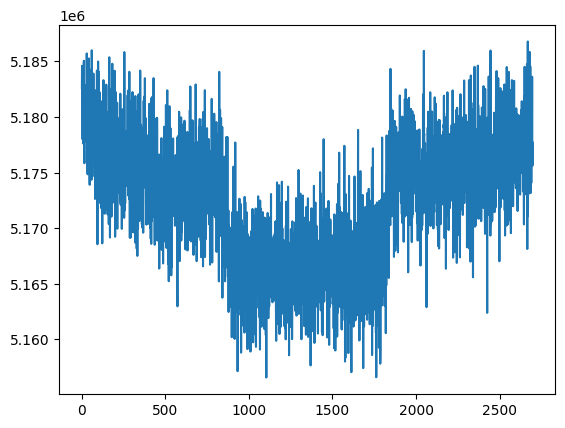

In [170]:
plt.plot(fgs1_binned.sum(axis=(1,2)))

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def smooth_data(data, window_size):
    return savgol_filter(data, window_size, 3)

def optimize_breakpoint(data, initial_breakpoint, window_size=500, buffer_size=50, smooth_window=121):
    best_breakpoint = initial_breakpoint
    best_score = float("-inf")
    midpoint = len(data) // 2
    smoothed_data = smooth_data(data, smooth_window)
#     smoothed_data=data
    

    for i in range(-window_size, window_size):
        new_breakpoint = initial_breakpoint + i
        if new_breakpoint > buffer_size and new_breakpoint < midpoint - buffer_size:
            region1 = data[: new_breakpoint - buffer_size]
            region2 = data[
                new_breakpoint
                + buffer_size : 2 * midpoint
                - new_breakpoint
                - buffer_size
            ]
            region3 = data[2 * midpoint - new_breakpoint + buffer_size :]

            breakpoint_region1 = smoothed_data[new_breakpoint - buffer_size: new_breakpoint + buffer_size]
            breakpoint_region2 = smoothed_data[new_breakpoint - buffer_size: new_breakpoint + buffer_size]

            mean_diff = abs(np.mean(region1) - np.mean(region2)) + abs(
                np.mean(region2) - np.mean(region3)
            )
            var_sum = np.var(region1) + np.var(region2) + np.var(region3)
            range_at_breakpoint1 = (np.max(breakpoint_region1) - np.min(breakpoint_region1))
            range_at_breakpoint2 = (np.max(breakpoint_region2) - np.min(breakpoint_region2))

            mean_range_at_breakpoint = (range_at_breakpoint1 + range_at_breakpoint2) / 2

            score = mean_diff - 0.5 * var_sum + mean_range_at_breakpoint

            if score > best_score:
                best_score = score
                best_breakpoint = new_breakpoint

    return best_breakpoint
def find_and_plot_breakpoints(data, initial_breakpoint, buffer_size=1500, smooth_window=1001, window_size=3500):
    fig, ax = plt.subplots(figsize=(12, 6))

    optimized_breakpoint = optimize_breakpoint(
        data,
        initial_breakpoint,
        window_size=window_size,
        buffer_size=buffer_size,
        smooth_window=smooth_window
    )

    midpoint = len(data) // 2
    breakpoints = [optimized_breakpoint, 2 * midpoint - optimized_breakpoint]

    # Plot the results
    ax.plot(data, color='#4E79A7', alpha=0.7, label="Original Data")
    ax.plot(smooth_data(data, smooth_window), label="Smoothed Data", color='#F28E2B')

    for bp in breakpoints:
        ax.axvline(x=bp - buffer_size, color="r", linestyle="--")
        ax.axvline(x=bp + buffer_size, color="r", linestyle="--")
#         ax.axvspan(bp - buffer_size, bp + buffer_size, color="gray", alpha=0.3)

    ax.set_title("Breakpoints Analysis")
    ax.set_xlabel("Time step")
    ax.set_ylabel("Value")
    ax.legend()
    plt.show()

Buffer Size: Controls the width of the region around the breakpoint for analysis.
Smooth Window: Affects how much the data is smoothed, influencing noise reduction and feature preservation.
Window Size: Determines how far from the initial breakpoint the function will search for the optimal breakpoint.
Default Breakpoint: Serves as the starting point for optimization and should be based on prior knowledge or data exploration.

(2810,)


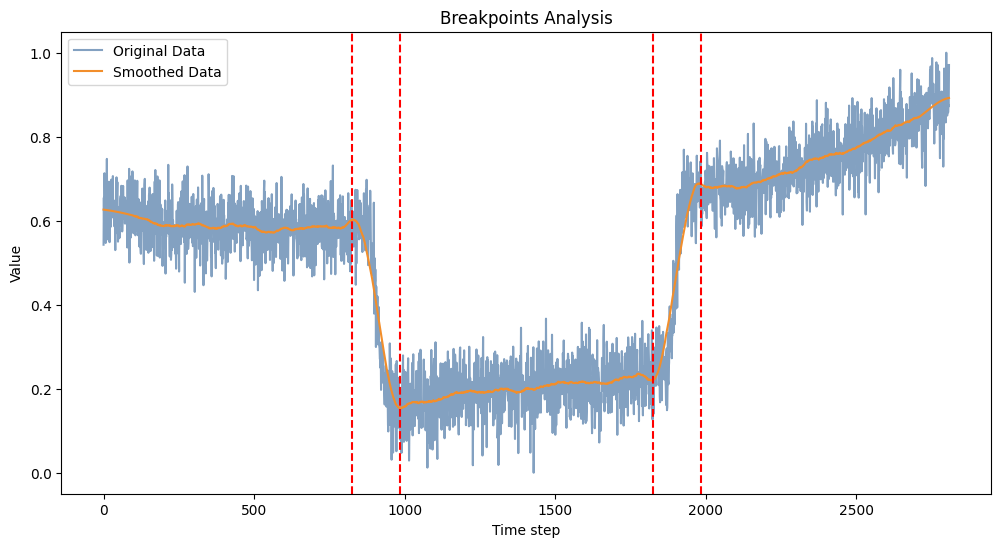

In [171]:

# Example usage
arr = airs_ch0_binned.sum(axis=(1, 2))
print(arr.shape)
# plt.plot(arr)
# arr=savgol_filter(arr, 100, 3)
initial_breakpoint=850
buffer_size=80 
smooth_window=200
window_size=300
# plt.plot(arr)
data=arr
data=(data-np.min(data))/(np.max(data)-np.min(data))
# plt.plot(data)

find_and_plot_breakpoints(data, initial_breakpoint, buffer_size, smooth_window, window_size)


In [ ]:
def method1(data):
    mean = np.mean(data)
    std = np.std(data)

    
    threshold = mean - 1* std
    dip_start = np.where(data < threshold)[0][0]
    dip_end = np.where(data < threshold)[0][-1]

    return dip_start , dip_end

def method2(data):
    window = 20
    moving_avg = np.convolve(data, np.ones(window)/window, mode='valid')

    dip_center = np.argmin(moving_avg) + window // 2
    width=80

    dip_start = max(0, dip_center - width)
    dip_end = min(len(data) - 1, dip_center + width)
    

# **FOR AIRS**

In [ ]:
mean = np.mean(data)
std = np.std(data)

threshold = mean - 1.5* std

dip_start = np.where(data < threshold)[0][0]
dip_end = np.where(data < threshold)[0][-1]

plt.figure(figsize=(12, 6))
plt.plot(data)
plt.axvline(x=dip_start, color='r', linestyle='--', label='Dip Start')
plt.axvline(x=dip_end, color='g', linestyle='--', label='Dip End')
plt.axhline(y=threshold, color='y', linestyle=':', label='Threshold')
plt.legend()
plt.title('Data with Detected Dip')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

print(f"Dip starts at index: {dip_start}")
print(f"Dip ends at index: {dip_end}")

# **FOR FSG**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

window = 20
moving_avg = np.convolve(data, np.ones(window)/window, mode='valid')

# Find the minimum point in the moving average
dip_center = np.argmin(moving_avg) + window // 2

width=30  # adjust 30 based on expected dip width
dip_start = max(0, dip_center - width)
dip_end = min(len(data) - 1, dip_center + width)
print(dip_start  , dip_end)
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.plot(range(window//2, len(moving_avg) + window//2), moving_avg, 'r', label='Moving Average')
plt.axvline(x=dip_start, color='g', linestyle='--', label='Dip Start')
plt.axvline(x=dip_end, color='r', linestyle='--', label='Dip End')
plt.legend()
plt.title('Data with Detected Dip using Moving Average')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

##Plot for AIRS-CH0
# plt.figure(figsize=(12, 4))
# plt.imshow(airs_ch0_final[0, :, :].T, aspect='auto')
# plt.title('AIRS-CH0 First Frame')
# plt.xlabel('Spatial Dimension')
# plt.ylabel('Wavelength')
# plt.colorbar(label='Flux')
# plt.show()

# #Plot for FGS1
# plt.figure(figsize=(6, 6))
# plt.imshow(fgs1_binned[0, :, :], aspect='auto')
# plt.title('FGS1 First Frame')
# plt.xlabel('Spatial Dimension')
# plt.ylabel('Spatial Dimension')
# plt.colorbar(label='Flux')
# plt.show()

# # Light curve plot
# plt.figure(figsize=(12, 4))
# airs_light_curve = airs_ch0_final.sum(axis=(1, 2))
# fgs_light_curve = fgs1_binned.sum(axis=(1, 2))
# plt.plot(airs_light_curve / airs_light_curve.mean(), label='AIRS-CH0')
# plt.plot(fgs_light_curve / fgs_light_curve.mean(), label='FGS1')
# plt.title('Normalized Light Curves')
# plt.xlabel('Time (frame index)')
# plt.ylabel('Normalized flux')
# plt.legend()
# plt.show()

In [ ]:
import pandas as pd
data = pd.read_csv("/kaggle/input/ariel-data-challenge-2024/train_labels.csv")
filtered_data = data[data["planet_id"] == planet].iloc[0, 1:].values
print(filtered_data.shape)
print(filtered_data[:4])

In [ ]:
def vector(arr, start, end):

    
    overall_avg = np.mean(arr)
    dip_avg = np.mean(arr[start:end+1])
    nondip_avg = np.mean(np.concatenate((arr[:start], arr[end:])))
    reduction = (nondip_avg - dip_avg) / nondip_avg
    
    nondip_std = np.std(np.concatenate((arr[:start], arr[end:])))
    dip_std = np.std(arr[start:end])
    
    dipcenter = (start + end) // 2
    dipcenter_value = arr[dipcenter]
    
    nondip_spike_diff1 = np.argmax(arr[:start] - np.argmin(arr[:start]))
    nondip_spike_diff2 = np.argmax(arr[end:] - np.argmin(arr[end:]))
    avgnondipspike_diff = (nondip_spike_diff1 + nondip_spike_diff2) / 2
    dip_spike_diff = np.argmax(arr[start:end+1] - np.argmin(arr[start:end+1]))
    

    vector = np.array([ overall_avg, dip_avg, nondip_avg, reduction, nondip_std, dip_std, dipcenter, dipcenter_value, nondip_spike_diff1, nondip_spike_diff2, avgnondipspike_diff, dip_spike_diff])

    return vector

arr= np.sum(airs_ch0_binned, axis=(1,2))
data=arr
data=(data-np.min(data))/(np.max(data)-np.min(data))


arr1=np.sum(fgs1_binned , axis=(1,2))
data1=arr1
data1=(data1-np.min(data1))/(np.max(data1)-np.min(data1))

    
vec=vector(data , 947 , 1865)
vec1=vector(data1 ,905 , 1815 )
in_vec=np.concatenate((vec , vec1))

In [ ]:
print(in_vec.shape)

In [ ]:
in_data=np.array(in_vec)
in_tensor=torch.tensor(in_data,dtype=torch.float32)
in_tensor=in_tensor.unsqueeze(0)
print(in_tensor.shape)

label_tensor=torch.tensor(filtered_data ,dtype=torch.float32)
label_tensor=label_tensor.unsqueeze(0)
print(label_tensor.shape)


# input_tensor = ((input_tensor -input_tensor.mean())/ input_tensor.std())*200
# label_tensor = (label_tensor / label_tensor.mean())

In [ ]:
print(label_tensor[0][:5])

In [ ]:
# plt.plot(label_tensor[0])

In [ ]:
torch.set_printoptions(precision=7)

In [ ]:
print(input_tensor[0][2])

# **MODELS**

In [ ]:
import torch
import torch.nn as nn

class WavelengthPredictor(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(WavelengthPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(24, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 283)
        )

    def forward(self, x):
        return self.model(x)

# Create model instance
model = WavelengthPredictor(dropout_rate=0.00)

# Calculate and print the number of parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

# Verify input and output shapes
input_tensor = torch.randn(1, 24)
output = model(input_tensor)
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {output.shape}")

In [ ]:
class WavelengthPredictor(nn.Module):
    def __init__(self):
        super(WavelengthPredictor, self).__init__()
        self.fc1 = nn.Linear(24, 128)  # Input layer
        self.fc2 = nn.Linear(128, 256) # Hidden layer 1
        self.fc3 = nn.Linear(256, 512) # Hidden layer 2
        self.fc4 = nn.Linear(512, 283) # Output layer
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.0)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

model = WavelengthPredictor()
# start at e-3 , decays to  1.5259e-08
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")


In [ ]:

class SpectralModel(nn.Module):
    def __init__(self, input_dim=5, output_dim=283):
        super(SpectralModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Create the model
model = SpectralModel()
# lr start at e-4 , it then decays to 1.2207e-08
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")


In [ ]:
epochs=5001
import os 
import torch.optim as optim

model.train()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-8)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  factor=0.9, patience=4, verbose=True)

for epoch in range(epochs):
    
    optimizer.zero_grad()
   
    x=in_tensor
    y=label_tensor
#     print(x.shape , y.shape)
    out=model(x)
    loss=criterion(out.squeeze(0), y.squeeze(0))
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    
    if epoch%200==0:
        print(f"loss at epoch {epoch} is " , loss.item() , out[0][:2] , y[0][:2])
    

In [ ]:
def epochnum(file):
    try:
        epoch_part = file.split('epoch')[1].split('-')[0]
        return int(epoch_part)
    except (IndexError, ValueError):
        return -1

path = "/kaggle/working"
pth_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.endswith('.pth')]
pth_files.sort(key=lambda x: epochnum(os.path.join(path, x)) , reverse=True)
# for file in pth_files[1:]:
    
#     os.remove(os.path.join(path , file))
# os.remove(os.path.join(path, "state.db"))
#     print(f"removed {file}")
# print(pth_files[1])

In [ ]:
for x in os.listdir("/kaggle/working/"):
    if x.endswith("pth"):
        os.remove(os.path.join("/kaggle/working/" , x))

In [ ]:
!rm -rf "/kaggle/working/*"

In [ ]:
import pandas as pd
planet_id=100468857
data = pd.read_csv("/kaggle/input/datasetforariel/neurips/100468857/ariel/train_labels.csv")
filtered_data = data[data["planet_id"] == planet_id].iloc[0, 1:].values
print(filtered_data.shape)


# weights="/kaggle/working/epoooch35-loss0.0129.pth"
# model = TransformerModel()
# model.load_state_dict(torch.load(weights))
# x=input_tensor
# y=model(x)
# print(y.shape)

# print(y[0][:10])
# print(label_tensor[0][:10])

In [ ]:
plt.plot(filtered_data)